## Tweet Sentiment Extraction (NLP)

This project extracts support phrases for English tweets' sentimental labels. The training data includes 27,481 tweets with sentiments and selected texts (support phrases). Sentiments divide into 40% tweets being neutral, 31% being positive and 28% being negative.

* Investigate top common words, special characters, and proportional length of support phrases
* Clean part of stop words, special characters and punctuations according to investigation results
* Compare results from Named-entity Recognition trained on cleaned and raw data for each sentiment
* Train a four-layer Neural Network embedded with Roberta for each sentiment

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from collections import Counter
# Identify which language a text is in.
import langdetect
import matplotlib.pyplot as plt
# Include plots
%matplotlib inline 
import math
import pickle
import nltk 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.stem import PorterStemmer
ps = PorterStemmer()
import tensorflow as tf
# Clean session
import tensorflow.keras.backend as K
# Don't hide long texts
pd.set_option('max_colwidth', 40)

# Roberta
from transformers import * 
import tokenizers

# NER
import spacy 
import random
from spacy.util import compounding
from spacy.util import minibatch
from tqdm import tqdm
import os

import warnings
warnings.filterwarnings("ignore")

### Investigate and Clean Data

In [2]:
train_raw = pd.read_csv("/Users/qingchuanlyu/Documents/Application/Projects/tweet_sentiment_extraction/input/train.csv")

In [3]:
train_raw[train_raw.isnull().any(axis=1)]

,textID,text,selected_text,sentiment
314,fdb77c3752,NaN,NaN,neutral


In [4]:
# There is only one missing value.
train_raw = train_raw.dropna()

In [5]:
# Check all texts are in english
alpha_data  = train_raw[train_raw['text'].str.contains('[a-zA-Z]')]
alpha_data['lang'] =alpha_data["text"].apply(lambda x: langdetect.detect(x))
alpha_data.head()

,textID,text,selected_text,sentiment,lang
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,en
1,549e992a42,Sooo SAD I will miss you here in Sa...,Sooo SAD,negative,en
2,088c60f138,my boss is bullying me...,bullying me,negative,en
3,9642c003ef,what interview! leave me alone,leave me alone,negative,en
4,358bd9e861,"Sons of ****, why couldn`t they put...","Sons of ****,",negative,en


In [6]:
alpha_data.loc[alpha_data.lang != "en"]
# Among 2065 rows categorized into languages other than English, they're either slangs or non-sense

,textID,text,selected_text,sentiment,lang
7,50e14c0bb8,Soooo high,Soooo high,neutral,so
26,852edc3769,I`m sorry.,I`m sorry.,negative,sv
42,2e7082d1c8,MAYDAY?!,MAYDAY?!,neutral,so
46,ddf296dffa,egh blah and boooooooooooo i dunno w...,SUCKKKKKK,negative,so
54,d8ba2a99a9,romance zero is funny,romance zero is funny,positive,pl
...,...,...,...,...,...
27395,b93f98a423,Think I have sunstroke.,Think I have sunstroke.,neutral,no
27422,b3270b06a3,"Plan, successful?","Plan, successful?",neutral,ro
27434,0a43c46417,Really good night,Really good night,positive,cy
27453,a01e5d1ddf,it`s beeen onee year,it`s beeen onee year,neutral,nl


In [7]:
# To count top common words, split texts.
train_raw['text_split'] = train_raw['selected_text'].apply(lambda x:x.split())
train_raw.head(5)

,textID,text,selected_text,sentiment,text_split
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,"[I`d, have, responded,, if, I, were,..."
1,549e992a42,Sooo SAD I will miss you here in Sa...,Sooo SAD,negative,"[Sooo, SAD]"
2,088c60f138,my boss is bullying me...,bullying me,negative,"[bullying, me]"
3,9642c003ef,what interview! leave me alone,leave me alone,negative,"[leave, me, alone]"
4,358bd9e861,"Sons of ****, why couldn`t they put...","Sons of ****,",negative,"[Sons, of, ****,]"


Text(0.5, 1.0, 'The most common words in positive raw tweets')

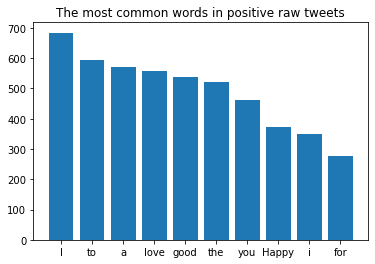

In [8]:
# Check the most common words for each sentiment (raw data, positive sentiment)
top = Counter([item for sublist in train_raw.loc[train_raw.sentiment=='positive']['text_split'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words','count']
plt.bar(temp['Common_words'], temp['count'])
plt.title('The most common words in positive raw tweets')
# Need to clean stop words and count again.

In [20]:
train_cl=train_raw.copy()

In [39]:
# Customize STOPWORDS: only pick words that don't signal a sentiment
STOPWORDS -= {"mustn't","would", "but", "only", "too", "over", "with", "down", "against", "won't", "haven't", "below", "like", "all", "can't", "not", "isn't", "wouldn't", 'off', "doesn't", 'ought', "aren't","didn't", "don't", 'no', "couldn't", 'cannot','what',"wasn't", "weren't",'above','nor', "shan't", "however", "hadn't",  "up", "why"}
STOPWORDS.add("I")
STOPWORDS.add("i`m")
STOPWORDS.add('day')
def remove_stopword(x):
    return [y for y in x.split() if y not in STOPWORDS]

# Remove STOPWORDS
train_cl.text = train_cl.text.astype(str)
train_cl.selected_text = train_cl.selected_text.astype(str)
train_cl['selected_text'] = train_cl['selected_text'].apply(lambda x: " ".join(remove_stopword(x)))
train_cl['text'] = train_cl['text'].apply(lambda x: " ".join(remove_stopword(x)))

In [22]:
# Any empty text?
train_cl[(train_cl.text == '') | (train_cl.selected_text == '')]

,textID,text,selected_text,sentiment,text_split
1510,65a3a7d925,http://tinyurl.com/d8fgxr,,neutral,"[this, is, for]"
2448,1760ca7893,goes one n only smirker cheers dave!...,,positive,"[the, be]"
9161,13259c1890,- wouldn`t miss world! ICCVB meeting...,,positive,[the]
10537,f42dd3e732,thought spanish name will pretend on...,,positive,"[because, i, do]"
10678,a482681447,,,positive,"[you, can, do, it]"
17274,770ca1632c,,,neutral,"[should, be, me]"
18876,fd7975b3fa,,,neutral,[same]
19592,b4e4fa2c30,_kritt GPS location: http://bit.ly/S...,,neutral,"[here, I, am]"
22749,279fd69360,,,neutral,"[I, did, that, once]"
26939,a33cec15dd,,,neutral,"[I, did]"


In [23]:
# Remove ten rows of empty selected texts
train_cl = train_cl[(train_cl.text != '') & (train_cl.selected_text != '')]

In [24]:
train_cl = train_cl.drop(['text_split'], axis = 1)
train_cl.head(5)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d responded, going","I`d responded, going",neutral
1,549e992a42,Sooo SAD will miss San Diego!!!,Sooo SAD,negative
2,088c60f138,boss bullying me...,bullying,negative
3,9642c003ef,what interview! leave alone,leave alone,negative
4,358bd9e861,"Sons ****, why couldn`t put releases...","Sons ****,",negative


In [25]:
# Stemming: chop off affixes
# I didn’t use Lemmantizer, because it often requires a “pos” to indicate a word is adjective or noun for accuracy.
train_cl['selected_text'] = train_cl['selected_text'].apply(lambda x: " ".join([ps.stem(word) for word in x.split()]))
train_cl['text'] = train_cl['text'].apply(lambda x: " ".join([ps.stem(word) for word in x.split()]))

In [26]:
train_cl.head(5)

,textID,text,selected_text,sentiment
0,cb774db0d1,"i`d responded, go","i`d responded, go",neutral
1,549e992a42,sooo sad will miss san diego!!!,sooo sad,negative
2,088c60f138,boss bulli me...,bulli,negative
3,9642c003ef,what interview! leav alon,leav alon,negative
4,358bd9e861,"son ****, whi couldn`t put releas al...","son ****,",negative


In [27]:
# Check texts that only contain special characters or punctuations
train_raw[~train_raw['text'].str.contains('[A-Za-z0-9]')]  

,textID,text,selected_text,sentiment,text_split
8120,4a265d8a34,****,****,negative,[****]
26005,0b3fe0ca78,?,?,neutral,[?]


In [29]:
# Texts that only contain * can be curses and signal negative sentiment
# Customize punctuations to remove
def remove_punctuations(x):
    return [word.translate(str.maketrans({',' : '', '`' : '', '.' : '', '|' : ''})) for word in x.split()]
train_cl['selected_text'] = train_cl['selected_text'].apply(lambda x: " ".join(remove_punctuations(x)))
train_cl['text'] = train_cl['text'].apply(lambda x: " ".join(remove_punctuations(x)))

In [30]:
train_cl=train_cl.drop(['textID'], axis = 1)

Text(0.5, 1.0, 'The most common words in cleaned data (positive sentiments)')

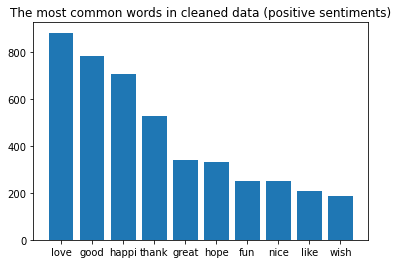

In [40]:
# Check again the most common words for each sentiment (cleaned data)
train_cl['text_split'] = train_cl['selected_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train_cl.loc[train_cl.sentiment=='positive']['text_split'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words','count']
plt.bar(temp['Common_words'], temp['count'])
plt.title('The most common words in cleaned data (positive sentiments)')
# 'Love,' 'good,' 'happi,' 'thank' and 'great' are strong signals of being a positive text, as expected.

Text(0.5, 1.0, 'The most common words in cleaned data (negative sentiments)')

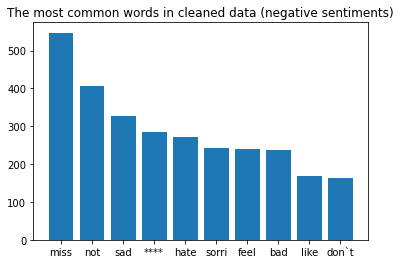

In [38]:
top = Counter([item for sublist in train_cl.loc[train_cl.sentiment=='negative']['text_split'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words','count']
plt.bar(temp['Common_words'], temp['count'])
plt.title('The most common words in cleaned data (negative sentiments)')
# 'Miss,' 'not,' 'sad,' '****' (probably a curse) and 'hate' are strong signals of being a negative text

Text(0.5, 1.0, 'The most common words in cleaned data (neutral sentiments)')

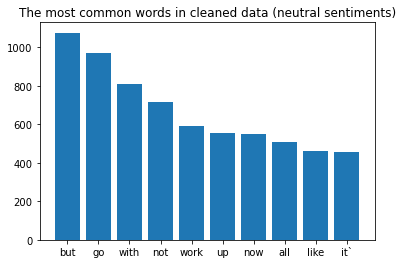

In [41]:
top = Counter([item for sublist in train_cl.loc[train_cl.sentiment=='neutral']['text_split'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words','count']
plt.bar(temp['Common_words'], temp['count'])
plt.title('The most common words in cleaned data (neutral sentiments)')

As different sentiments correspond to different most common words (different signals), this suggests I train models for different sentiment separately. Before training models, check the different length (number of words) between original and selected texts for each sentiment, and see if there's a trend.

In [62]:
# Calculate lengths of selected texts as the proportion of the length of original texts in training data. 
# Compute number of words in selected text.
train_raw['len_selected_text'] = train_raw['selected_text'].apply(lambda x:len(str(x).split())) 
# Compute number of words in original text.
train_raw['len_text'] = train_raw['text'].apply(lambda x:len(str(x).split())) 
# Compute the difference between lengths. should be always non-negative.
train_raw['difference_in_words'] = train_raw['len_text'] - train_raw['len_selected_text']
train_raw['difference_in_words'].mode(), train_raw['difference_in_words'].median(), train_raw['difference_in_words'].mean()
# 0 is the mode of length difference between texts and selected_texts.
# 2 is the median of length difference between texts and selected_texts
# 5.8 is the mean of length difference between texts and selected_texts. 

(0    0
 dtype: int64,
 2.0,
 5.8003639010189225)

Text(0, 0.5, 'Counts')

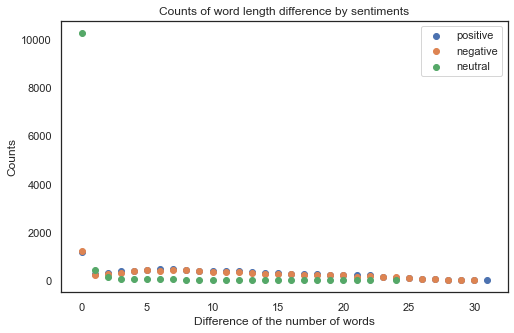

In [63]:
# Check the difference of numbers of words for different sentiments
sentiments = ['positive', 'negative', 'neutral']
fig, ax = plt.subplots(figsize=(8,5))
for s in sentiments:
    temp = train_raw.loc[(train_raw.sentiment == s)]\
           .groupby('difference_in_words').agg(length_diff_count= ('difference_in_words', 'size')).reset_index()
    ax.scatter(temp['difference_in_words'], temp['length_diff_count'])
    ax.legend(sentiments)
ax.set_title('Counts of word length difference by sentiments')
ax.set_xlabel('Difference of the number of words')
ax.set_ylabel('Counts')

In [21]:
# Check the number of tweets for each sentiment
len(train_raw.loc[train_raw.sentiment == 'neutral']), len(train_raw.loc[train_raw.sentiment == 'positive']), len(train_raw.loc[train_raw.sentiment == 'negative'])
# Almost all neutral tweets have the support phrases the same as the whole text

(11117, 8582, 7781)

In [75]:
train_cl = train_cl.drop(['text_split'], axis = 1)
train_raw = train_raw.drop(['text_split', 'len_selected_text', 'len_text', 'difference_in_words'], axis = 1)

In [78]:
train_raw.head(5)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in Sa...,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put...","Sons of ****,",negative


The above plot shows that neutral texts, different from positive and negative texts, have a significantly large amount of selected texts with the same length as the original texts. The distribution of counts of positive and negative texts are similar most of time. This confirms the previous observation: I need to train models for different sentiments separately.

### Train the cleaned data with Named-Entity Recognition
Train data for each sentiment separately. Take the support phrases (selected texts) as entities.

In [64]:
# Define the model path of each sentiment
def get_model_out_path(sentiment):
    model_out_path = None
    if sentiment == 'positive':
        model_out_path = '/Users/qingchuanlyu/Documents/Application/Projects/tweet_sentiment_extraction/NER/models_cl/model_pos'
    elif sentiment == 'negative':
        model_out_path = '/Users/qingchuanlyu/Documents/Application/Projects/tweet_sentiment_extraction/NER/models_cl/model_neg'
    else:
        model_out_path = '/Users/qingchuanlyu/Documents/Application/Projects/tweet_sentiment_extraction/NER/models_cl/model_neu'
    return model_out_path

In [65]:
# Saving the paths of the trained models
def save_model(output_dir, nlp, new_model_name):
    output_dir = '/Users/qingchuanlyu/Documents/Application/Projects/{output_dir}'
    if output_dir is not None:        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        nlp.meta["name"] = new_model_name
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

In [66]:
# Pass model = None to train on data directly
# Pass model = nl to train on top of the existing models
def train(train_data, output_dir, n_iter=10, model=None):
    """Load the model, set up the pipeline and train the entity recognizer."""
    ""
    if model is not None:
        nlp = spacy.load(output_dir)  # Load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # Create blank Language class
        print("Created blank 'en' model")
    
    
    # Create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spacy
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner, last=True)
    else:
        ner = nlp.get_pipe("ner")
    
    # Add end positions of support phrases
    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    # Disable other pipelines than 'ner'.
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):  #only train NER
        if model is None:
            nlp.begin_training()
        else:
            nlp.resume_training()
        # NER model has to loop over examples
        for itn in tqdm(range(n_iter)): # tqdm shows a progress bar
            random.shuffle(train_data)
            # Minibatch function uses the size parameter to denote the batch size. 
            # Use the utility function 'compounding' to generate series of compounding values.
            # Compounding(start, end, compounding factor): start * factor * factor ... till end
            batches = minibatch(train_data, size=compounding(4.0, 500.0, 1.001))    
            # Losses: A dictionary to hold the losses against each pipeline component. 
            losses = {}
            for batch in batches:
                # Use * for unpack in zip()
                texts, annotations = zip(*batch)
                nlp.update(
                    texts,
                    annotations,  # Entities
                    drop=0.5,   # Dropout rate in a neural network: prevent overfitting
                    losses=losses, 
                )
            
            print("Losses", losses)
    save_model(output_dir, nlp, 'st_ner')

In [67]:
# Empty texts or selected texts cannot be used with spacy NER
np.where(train_cl.applymap(lambda x: x == ''))

(array([], dtype=int64), array([], dtype=int64))

In [68]:
# Use support phrases as entities.
def get_training_data(sentiment, train_df):
    train_data = []
    for index, row in train_df.iterrows():
        if row.sentiment == sentiment:
            # Remove leading/trailing white spaces.
            selected_text = row.selected_text.strip()
            text = row.text.strip()
            start = text.find(selected_text)
            end = start + len(selected_text)
            train_data.append((text, {"entities": [[start, end, 'selected_text']]}))
    return train_data

In [79]:
sentiment = 'positive'

train_data = get_training_data(sentiment, train_cl)
model_path = get_model_out_path(sentiment)

train(train_data, model_path, n_iter=8, model=None)

  0%|          | 0/8 [00:00<?, ?it/s]

Created blank 'en' model


 12%|█▎        | 1/8 [00:45<05:17, 45.34s/it]

Losses {'ner': 25736.788739059004}


 25%|██▌       | 2/8 [01:25<04:22, 43.81s/it]

Losses {'ner': 23528.080547430916}


 38%|███▊      | 3/8 [02:05<03:33, 42.71s/it]

Losses {'ner': 22666.227156140325}


 50%|█████     | 4/8 [02:47<02:50, 42.58s/it]

Losses {'ner': 21953.839725222875}


 62%|██████▎   | 5/8 [03:28<02:06, 42.00s/it]

Losses {'ner': 21568.206311614515}


 75%|███████▌  | 6/8 [04:11<01:24, 42.27s/it]

Losses {'ner': 20921.38878667863}


 88%|████████▊ | 7/8 [04:58<00:43, 43.75s/it]

Losses {'ner': 20385.057398884404}


100%|██████████| 8/8 [05:48<00:00, 43.56s/it]

Losses {'ner': 19879.090874361213}
Saved model to /Users/qingchuanlyu/Documents/Application/Projects/{output_dir}


In [80]:
sentiment = 'neutral'

train_data = get_training_data(sentiment, train_cl)
model_path = get_model_out_path(sentiment)

train(train_data, model_path, n_iter=8, model=None)

  0%|          | 0/8 [00:00<?, ?it/s]

Created blank 'en' model


 12%|█▎        | 1/8 [00:53<06:14, 53.50s/it]

Losses {'ner': 6065.923520103242}


 25%|██▌       | 2/8 [01:53<05:33, 55.53s/it]

Losses {'ner': 4993.1503220444165}


 38%|███▊      | 3/8 [02:50<04:39, 55.83s/it]

Losses {'ner': 4852.670993003616}


 50%|█████     | 4/8 [03:48<03:45, 56.41s/it]

Losses {'ner': 4984.31676011499}


 62%|██████▎   | 5/8 [04:44<02:49, 56.42s/it]

Losses {'ner': 4859.370355415915}


 75%|███████▌  | 6/8 [05:39<01:51, 55.91s/it]

Losses {'ner': 4530.855946970908}


 88%|████████▊ | 7/8 [06:33<00:55, 55.57s/it]

Losses {'ner': 4401.452591465702}


100%|██████████| 8/8 [07:28<00:00, 56.07s/it]

Losses {'ner': 4435.302763551918}
Saved model to /Users/qingchuanlyu/Documents/Application/Projects/{output_dir}


In [81]:
sentiment = 'negative'

train_data = get_training_data(sentiment, train_cl)
model_path = get_model_out_path(sentiment)

train(train_data, model_path, n_iter=8, model=None)

  0%|          | 0/8 [00:00<?, ?it/s]

Created blank 'en' model


 12%|█▎        | 1/8 [00:45<05:17, 45.31s/it]

Losses {'ner': 24130.485537197324}


 25%|██▌       | 2/8 [01:27<04:26, 44.48s/it]

Losses {'ner': 21531.001712200203}


 38%|███▊      | 3/8 [02:05<03:31, 42.39s/it]

Losses {'ner': 19999.51426567797}


 50%|█████     | 4/8 [02:45<02:47, 41.78s/it]

Losses {'ner': 19096.220653970522}


 62%|██████▎   | 5/8 [03:25<02:03, 41.04s/it]

Losses {'ner': 18887.610484619305}


 75%|███████▌  | 6/8 [04:01<01:19, 39.76s/it]

Losses {'ner': 18134.17002244748}


 88%|████████▊ | 7/8 [04:47<00:41, 41.45s/it]

Losses {'ner': 17544.241354654434}


100%|██████████| 8/8 [05:37<00:00, 42.17s/it]

Losses {'ner': 17377.976046328782}
Saved model to /Users/qingchuanlyu/Documents/Application/Projects/{output_dir}


In [ ]:
# Predict with the trained models for each sentiment.
def predict_entities(text, model):
    doc = model(text)
    ent_array = []
    # doc.ents: the named entities in the document. 
    # doc.ents returns a tuple of named entity Span objects, if the entity recognizer has been applied.
    for ent in doc.ents:
        start = text.find(ent.text)
        end = start + len(ent.text)
        new_int = [start, end, ent.label_]
        if new_int not in ent_array:
            ent_array.append([start, end, ent.label_])
    # If the machine doesn't recognize an entity(support phrase), then use the original text.
    selected_text = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else text
    return selected_text

In [ ]:
# Jaccard Index (similarity scores) = intersection / union.
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0): return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [82]:
trained_models_base_path = '/Users/qingchuanlyu/Documents/Application/Projects/tweet_sentiment_extraction/NER/models_cl/'
if trained_models_base_path is not None:
    print("Loading Models  from ", trained_models_base_path)
    model_pos = spacy.load(trained_models_base_path + 'model_pos')
    model_neg = spacy.load(trained_models_base_path + 'model_neg')
    model_neu = spacy.load(trained_models_base_path + 'model_neu')
        
    jaccard_score = 0
    for index, row in tqdm(train_cl.iterrows(), total=train_cl.shape[0]): # tqdm shows a progress bar
        text = row.text
        if row.sentiment == 'neutral':
            jaccard_score += jaccard(predict_entities(text, model_neu), row.selected_text)
        elif row.sentiment == 'positive':
            jaccard_score += jaccard(predict_entities(text, model_pos), row.selected_text)
        else:
            jaccard_score += jaccard(predict_entities(text, model_neg), row.selected_text) 
        
    print(f'Average Jaccard Score is {jaccard_score / train_cl.shape[0]}')

Loading Models  from  /Users/qingchuanlyu/Documents/Application/Projects/tweet_sentiment_extraction/NER/models_cl/


100%|██████████| 27473/27473 [01:55<00:00, 237.93it/s]

Average Jaccard Score is 0.6814476358382915


### Train the raw data with Named-Entity Recognition
I used the same modeling approach. The only difference is now the raw data has all the original punctuations, special characters and stopping words. The purpose is to see if the Jaccard Index will be improved by including a little "noise." Leading and trailing spaces still have to be removed for modeling purposes. 

In [83]:
# Redefine output paths.
def get_model_out_path(sentiment):
    model_out_path = None
    if sentiment == 'positive':
        model_out_path = '/Users/qingchuanlyu/Documents/Application/Projects/NER/models_raw/model_pos'
    elif sentiment == 'negative':
        model_out_path = '/Users/qingchuanlyu/Documents/Application/Projects/NER/models_raw/model_neg'
    else:
        model_out_path = '/Users/qingchuanlyu/Documents/Application/Projects/NER/models_raw/model_neu'
    return model_out_path

In [84]:
sentiment = 'positive'

train_data = get_training_data(sentiment, train_raw)
model_path = get_model_out_path(sentiment)

train(train_data, model_path, n_iter=8, model=None)

  0%|          | 0/8 [00:00<?, ?it/s]

Created blank 'en' model


 12%|█▎        | 1/8 [01:03<07:22, 63.27s/it]

Losses {'ner': 34495.94609348581}


 25%|██▌       | 2/8 [02:04<06:15, 62.59s/it]

Losses {'ner': 31534.41414805119}


 38%|███▊      | 3/8 [03:04<05:09, 61.98s/it]

Losses {'ner': 29852.290283935185}


 50%|█████     | 4/8 [04:05<04:06, 61.71s/it]

Losses {'ner': 29023.090044928515}


 62%|██████▎   | 5/8 [05:07<03:05, 61.78s/it]

Losses {'ner': 28050.829018994376}


 75%|███████▌  | 6/8 [06:03<01:59, 59.82s/it]

Losses {'ner': 27570.81122575834}


 88%|████████▊ | 7/8 [07:04<01:00, 60.21s/it]

Losses {'ner': 26417.417637890263}


100%|██████████| 8/8 [08:23<00:00, 62.92s/it]

Losses {'ner': 26469.83920600991}
Saved model to /Users/qingchuanlyu/Documents/Application/Projects/{output_dir}


In [85]:
sentiment = 'negative'

train_data = get_training_data(sentiment, train_raw)
model_path = get_model_out_path(sentiment)

train(train_data, model_path, n_iter=8, model=None)

Created blank 'en' model


 12%|█▎        | 1/8 [01:00<07:05, 60.85s/it]

Losses {'ner': 31888.50084549922}


 25%|██▌       | 2/8 [01:54<05:52, 58.70s/it]

Losses {'ner': 29067.340677474087}


 38%|███▊      | 3/8 [03:06<05:12, 62.55s/it]

Losses {'ner': 27383.918844106625}


 50%|█████     | 4/8 [04:39<04:47, 71.79s/it]

Losses {'ner': 26737.240188338023}


 62%|██████▎   | 5/8 [06:19<04:01, 80.37s/it]

Losses {'ner': 25402.630098945898}


 75%|███████▌  | 6/8 [07:50<02:46, 83.35s/it]

Losses {'ner': 24267.038133249363}


 88%|████████▊ | 7/8 [09:14<01:23, 83.71s/it]

Losses {'ner': 23704.522552007526}


100%|██████████| 8/8 [10:34<00:00, 79.32s/it]

Losses {'ner': 23441.1051843297}
Saved model to /Users/qingchuanlyu/Documents/Application/Projects/{output_dir}


In [86]:
sentiment = 'neutral'

train_data = get_training_data(sentiment, train_raw)
model_path = get_model_out_path(sentiment)

train(train_data, model_path, n_iter=8, model=None)

Created blank 'en' model


 12%|█▎        | 1/8 [01:41<11:47, 101.13s/it]

Losses {'ner': 7062.446562918399}


 25%|██▌       | 2/8 [03:15<09:53, 98.98s/it] 

Losses {'ner': 5464.664182666726}


 38%|███▊      | 3/8 [04:58<08:21, 100.21s/it]

Losses {'ner': 5397.69580260112}


 50%|█████     | 4/8 [06:43<06:46, 101.73s/it]

Losses {'ner': 5286.877572375808}


 62%|██████▎   | 5/8 [08:23<05:03, 101.08s/it]

Losses {'ner': 5134.323974655159}


 75%|███████▌  | 6/8 [10:05<03:23, 101.51s/it]

Losses {'ner': 5295.005934208741}


 88%|████████▊ | 7/8 [11:45<01:41, 101.05s/it]

Losses {'ner': 4919.467996960818}


100%|██████████| 8/8 [13:26<00:00, 100.78s/it]

Losses {'ner': 4914.747258997393}
Saved model to /Users/qingchuanlyu/Documents/Application/Projects/{output_dir}


In [89]:
# Compute avg Jaccard Index again (raw data)
TRAINED_MODELS_BASE_PATH = '/Users/qingchuanlyu/Documents/Application/Projects/tweet_sentiment_extraction/NER/models_raw/'
if TRAINED_MODELS_BASE_PATH is not None:
    print("Loading Models  from ", TRAINED_MODELS_BASE_PATH)
    model_pos = spacy.load(TRAINED_MODELS_BASE_PATH + 'model_pos')
    model_neg = spacy.load(TRAINED_MODELS_BASE_PATH + 'model_neg')
    model_neu = spacy.load(TRAINED_MODELS_BASE_PATH + 'model_neu')
        
    jaccard_score = 0
    for index, row in tqdm(train_raw.iterrows(), total=train_raw.shape[0]):
        text = row.text
        if row.sentiment == 'neutral':
            jaccard_score += jaccard(predict_entities(text, model_neu), row.selected_text)
        elif row.sentiment == 'positive':
            jaccard_score += jaccard(predict_entities(text, model_pos), row.selected_text)
        else:
            jaccard_score += jaccard(predict_entities(text, model_neg), row.selected_text) 
        
    print(f'Average Jaccard Score is {jaccard_score / train_raw.shape[0]}')

Loading Models  from  /Users/qingchuanlyu/Documents/Application/Projects/tweet_sentiment_extraction/NER/models_raw/


100%|██████████| 27480/27480 [01:57<00:00, 234.11it/s]

Average Jaccard Score is 0.7794439920934414


Jaccard Score with raw data (0.78) is slightly higher than that with the cleaned texts (0.68).

### Train CNN embedded with RoBERTa
RoBERTa is a bi-directional encoder pre-training system. It already takes care of special characters, stopping words and punctuations. Therefore, I trained raw data with a convolutional neural network embedded with RoBERTa for each sentiment.

In [70]:
train_rb = train_raw.copy()

In [84]:
# The maximum positional embedding size here is the maximum length provided as the input sequence length
MAX_LEN = 512
# Incorporate texts of different lengths into a tensor
PAD_ID = 1
# Learning rate
lr = 0.012
SEED = 88888
tf.random.set_seed(SEED)
np.random.seed(SEED)
# Overconfidence: increase uncertainties
LABEL_SMOOTHING = 0.1
# Overfitting
Dropout_new = 0.18     
n_split = 5            

# Input training data was sorted by sentiments
# The last index of each sentiment category
sentiment_id = {'positive': 1313, 'negative': 2430, 'neutral': 7974}

In [88]:
# Pre-trained model path
PATH = '/Users/qingchuanlyu/Documents/Application/Projects/tweet_sentiment_extraction/TF_Roberta/'
tokenizer = tokenizers.ByteLevelBPETokenizer(
    PATH+'vocab-roberta-base.json', 
    PATH+'merges-roberta-base.txt', 
    lowercase=True,
    add_prefix_space=True
)

In [89]:
# Token indices: numerical representations of tokens building the sequences that will be used as input by the model.
input_ids = np.ones((ct,MAX_LEN),dtype='int32')
# Attention mask: a binary tensor indicating the position of the padded indices so that the model does not attend to them.
attention_mask = np.zeros((ct,MAX_LEN),dtype='int32')
# Token_type_ids: a binary mask identifying the two types of sequence in the model, such as a question or an answer.
token_type_ids = np.zeros((ct,MAX_LEN),dtype='int32')

start_tokens = np.zeros((ct,MAX_LEN),dtype='int32')
end_tokens = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(train.shape[0]): # Access to the k'th row
    
    # Find overlaps between texts and selected texts
    text1 = " "+" ".join(train_rb.loc[k,'text'].split())
    text2 = " ".join(train_rb.loc[k,'selected_text'].split())
    # The lowest index of the substring: starting point of selected text in a text
    #if not found, return -1
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    # Mark selected text as 1
    chars[idx:idx+len(text2)]=1 
    enc = tokenizer.encode(text1)  
        
    # Offset index of word in texts: beginning and length of words.
    offsets = []; idx=0
    for t in enc.ids:
        w = tokenizer.decode([t])
        offsets.append((idx,idx+len(w)))
        idx += len(w)
    
    toks = []
    # Append each word's index to toks, if it's part of a support phrase.
    for i,(a,b) in enumerate(offsets):
        sm = np.sum(chars[a:b])
        if sm>0: toks.append(i) 
        
    # Extract the representative tokens of sentiments.
    s_tok = sentiment_id[train.loc[k,'sentiment']]
    # Besides binary indicators, add an additional token 2 at the end.
    input_ids[k,:len(enc.ids)+3] = [0, s_tok] + enc.ids + [2]
    # Mark padded indices.
    attention_mask[k,:len(enc.ids)+3] = 1
    # Mark starting and ending positions of support phrases.
    if len(toks)>0:
        start_tokens[k,toks[0]+2] = 1
        end_tokens[k,toks[-1]+2] = 1

In [104]:
# Define a networking model with Tensorflow
def build_model():
    ids = tf.keras.layers.Input((max_len,), dtype = tf.int32)
    att = tf.keras.layers.Input((max_len,), dtype = tf.int32)
    tok = tf.keras.layers.Input((max_len,), dtype = tf.int32)

    config = RobertaConfig.from_pretrained(path + 'config-roberta-base.json')
    bert_model = TFRobertaModel.from_pretrained(path + 'pretrained-roberta-base.h5',config = config)
    x = bert_model(ids,attention_mask=att,token_type_ids = tok)
    
    # Randomly sets input units to 0 with a frequency of dropout rates at each step.
    x1 = tf.keras.layers.Dropout(0.1)(x[0]) 
    # 1D operates on input and kernel (filter): 128 * (2-dimensional vectors).
    # Add padding evenly to the left/right or up/down of the input.
    x1 = tf.keras.layers.Conv1D(128, 2,padding='same')(x1)
    # Use the leaky version to avoid many dead neurons produced by a plain rectifier.
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Conv1D(64, 2,padding='same')(x1)
    x1 = tf.keras.layers.Dense(1)(x1) # Densely connected.
    x1 = tf.keras.layers.Flatten()(x1)
    # Use softmax as two classes, being a support phrase or not, are mutually exclusive.
    x1 = tf.keras.layers.Activation('softmax')(x1)
    
    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1])
    # Adam assigns more learning rate to sparse words and doesn't require a learning_rate to start with.
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    # Use binary crossentropy loss (MLE) to evaluate binary prediction.
    model.compile(loss='binary_crossentropy', optimizer=optimizer)

    return model

In [ ]:
# Initialize predicting windows
preds_start = np.zeros((input_ids.shape[0], MAX_LEN))
preds_end = np.zeros((input_ids.shape[0], MAX_LEN))

DISPLAY=1
for i in range(5):
    K.clear_session()
    model = build_model()
    model.save_weights('/Users/qingchuanlyu/Documents/Application/Projects/tweet_sentiment_extraction/pretrained_tweet_weights/v4-roberta-%i.h5'%i)
    model.load_weights('/Users/qingchuanlyu/Documents/Application/Projects/tweet_sentiment_extraction/pretrained_tweet_weights/v4-roberta-%i.h5'%i)
    
    print('Predicting support phrases...')
    preds = model.predict([input_ids,attention_mask,token_type_ids],verbose=DISPLAY)
    preds_start += preds[0]/n_splits
    preds_end += preds[1]/n_splits

In [ ]:
# Output the predicted support phrases as a new column in the training set.
all = []
for k in range(input_ids.shape[0]):
    a = np.argmax(preds_start[k,])
    b = np.argmax(preds_end[k,])
    if a>b: 
        st = train.loc[k,'text']
    else:
        text1 = " "+" ".join(train.loc[k,'text'].split())
        enc = tokenizer.encode(text1)
        st = tokenizer.decode(enc.ids[a-1:b])
    all.append(st)
train['selected_text_predicted'] = all

In [ ]:
jaccard_score = 0
for index, row in tqdm(train.iterrows(), total=train.shape[0]):
    jaccard_score += jaccard(row.selected_text_predicted, row.selected_text)
    
print(f'Average Jaccard Score is {jaccard_score / train.shape[0]}')

It took a very long time to train CNN embedded with Roberta, so I moved the last three cells to an online API with a GPU accelerator.

The average Jaccard Score was 0.74 by using CNN embedded with Roberta, higher than the Jaccard Index of training NER with the cleaned data (0.68) and lower than the Jaccard Index of training NER with the raw data (0.78). Besides, NER has a much less training time compared with that of Roberta (29 minutes vs greater than 1 hour 48 minutes without GPU). Below are the screenshots of CNN plus Roberta results with GPU (<15 minutes):

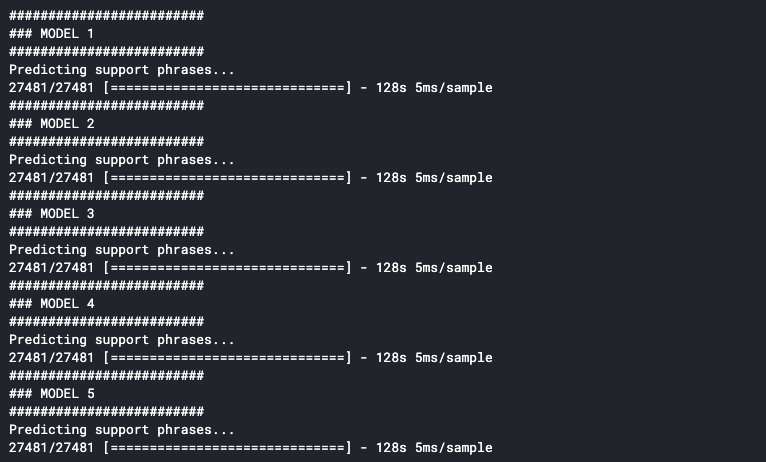

In [2]:
Image('/Users/qingchuanlyu/Documents/Application/Projects/tweet_sentiment_extraction/CNN_progress_bars.png')

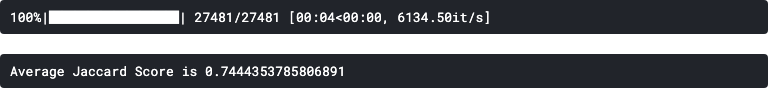

In [3]:
Image('/Users/qingchuanlyu/Documents/Application/Projects/tweet_sentiment_extraction/CNN_Jaccard_Index.png')